## Model

In [1]:
import torch
import torch.nn as nn

In [2]:
import matplotlib.pyplot as plt

In [3]:
class Network(torch.nn.Module):
    def __init__(self):

        super(Network, self).__init__()
        
        self.initial_conv_layers = nn.Sequential(
                                nn.Conv2d(3, 16, 9), # x-8
                                nn.PReLU(),
                                nn.Conv2d(16, 32, 7), # x-8-6 = x-14
                                nn.PReLU()
                              )
        
        self.gdf_conv1 = nn.Conv2d(32, 16, 9)
        self.gdf_max1 = nn.MaxPool2d(2)
        self.gdf_avg1 = nn.AvgPool2d(2)
        self.gdf_prelu1 = nn.PReLU()
        
        self.gdf_conv2 = nn.Conv2d(16, 32, 7)
        self.gdf_max2 = nn.MaxPool2d(2)
        self.gdf_avg2 = nn.AvgPool2d(2)
        self.gdf_prelu2 = nn.PReLU()
        
        self.gdf_conv3_block = nn.Sequential(
                            nn.Conv2d(32, 16, 7, 1, 3), # x-6 + 6 = x
                            nn.PReLU(),
#                             nn.Conv2d(16, 8, 7, 1, 3), 
                            nn.Conv2d(16, 8, 6, 1, 4), #Trying to get all WxH same x-5+8 = x+3
                            nn.PReLU()
                          )
        
        self.gdf_adp = nn.AdaptiveMaxPool2d((64,64))
        self.gdf_adp_prelu = nn.PReLU()
        
        self.gdf_fc_block = nn.Sequential(
            nn.Linear(64*64*8, 512),
            nn.PReLU(),
            nn.Linear(512, 5)
        )
        
        self.cc1_conv1 = nn.Conv2d(32, 20, 7)
        self.cc1_max1 = nn.MaxPool2d(2)
        self.cc1_avg1 = nn.AvgPool2d(2)
        self.cc1_prelu1 = nn.PReLU()
        
        self.cc1_conv2 = nn.Conv2d(20, 40, 5)
        self.cc1_max2 = nn.MaxPool2d(2)
        self.cc1_avg2 = nn.AvgPool2d(2)
        self.cc1_prelu2 = nn.PReLU()
        
        self.cc1_conv3_block = nn.Sequential(
                            nn.Conv2d(40, 20, 5, 1, 2), # x - 4 + 4 = x
                            nn.PReLU(),
#                             nn.Conv2d(20, 10, 5, 1, 2), 
                            nn.Conv2d(20, 10, 4, 1, 2), # Trying to make all WxH same  x-3+4 = x+1
                            nn.PReLU()
                          )
        
        
        self.cc2_conv1 = nn.Conv2d(32, 24, 5)
        self.cc2_max1 = nn.MaxPool2d(2)
        self.cc2_avg1 = nn.AvgPool2d(2)
        self.cc2_prelu1 = nn.PReLU()
        
        self.cc2_conv2 = nn.Conv2d(24, 48, 3)
        self.cc2_max2 = nn.MaxPool2d(2)
        self.cc2_avg2 = nn.AvgPool2d(2)
        self.cc2_prelu2 = nn.PReLU()
        
        self.cc2_conv3_block = nn.Sequential(
                            nn.Conv2d(48, 24, 3, 1, 1), # x-2+2 = x
                            nn.PReLU(),
                            nn.Conv2d(24, 12, 3, 1, 1), #x-2+2 = x
                            nn.PReLU()
                          )
        

        self.out_block = nn.Sequential(
                        nn.Conv2d(30, 24, 3, 1, 1), # 24, 50-2+2 = 50 (x)
                        nn.PReLU(),
                        nn.Conv2d(24, 32, 3, 1, 1), # 32, 50-2+2 = 50 (x)
                        nn.PReLU(),
                        nn.ConvTranspose2d(32, 16, 7, 2, 1, dilation=2), # 16, (50-1)*2 - 2*1 + 1*(3-1) + 1 = 99 (2*x-1)
                        nn.PReLU(),
                        nn.ConvTranspose2d(16, 8, 6, 2, 1, dilation=2), # 8, (99-1)*2 - 2*1 + 1*(3-1) + 1 = 197 (4*x-3)
                        nn.PReLU(),
                        nn.Conv2d(8, 8, 1), # 8, 197
                        nn.PReLU(),
                        nn.Conv2d(8, 1, 1) # 1, 197
                    )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Initial batch_sizex3x225x225
#         print(x.shape)
        pre_x = self.initial_conv_layers(x)  # 32,225-14 = 211 (x-14)
        
        # sub task 1
        
        gd_x = self.gdf_conv1(pre_x) # 211-8 = 16,203 (x-22)
        gd_x = self.gdf_max1(gd_x) + self.gdf_avg1(gd_x) # 203/2 = 101 ((x-22)/2)
        gd_x = self.gdf_prelu1(gd_x) 
        
        gd_x = self.gdf_conv2(gd_x) # 32,101-6 = 95 ((x-22)/2 - 6) = ((x-34)/2)
        gd_x = self.gdf_max2(gd_x) + self.gdf_avg2(gd_x) # 95/2 = 47 ((x-34)/4)
        gd_x = self.gdf_prelu2(gd_x) 
        
#         print("Before gd_b: ", gd_x.shape)
        
        gd_out = self.gdf_conv3_block(gd_x) # 8, 47+3 = 50 (x-34/4 + 3 = (x-22/4))
        
#         print("After gd_b: ", gd_out.shape)

        
        gd_b = self.gdf_adp(gd_out) # 8, 64
        gd_b = self.gdf_adp_prelu(gd_b)
#         print('Shape after gd adaptive pooling is: ',gd_b.shape)
#         gd_b = gd_b.reshape(-1) 
        gd_b = torch.flatten(gd_b, 1)
#         print('Shape after flatten is: ',gd_b.shape)
        gd_b = self.gdf_fc_block(gd_b)
        
        # sub task 2
        
        # First branch
        cc_1 = self.cc1_conv1(pre_x) # 20, 211-6 = 205 (x-20)
        cc_1 = self.cc1_max1(cc_1) + self.cc1_avg1(cc_1) # 205/2 = 102 (x-20/2)
        cc_1 = self.cc1_prelu1(cc_1)
        
        cc_1 = self.cc1_conv2(cc_1) # 40, 102-4 = 98 ((x-20)/2 - 4 = (x-28)/2)
        cc_1 = self.cc1_max2(cc_1) + self.cc1_avg2(cc_1) # 98/2 = 49 ((x-28)/4)
        cc_1 = self.cc1_prelu2(cc_1)
        
#         print("Before cc block: ", cc_1.shape)
        
        cc_1 = self.cc1_conv3_block(cc_1) # 10, 49+1 = 50
#         print("cc_1 shape is: ", cc_1.shape)

        
        # Second branch
        cc_2 = self.cc2_conv1(pre_x) # 24, 211-4 = 207 (x-18)
        cc_2 = self.cc2_max1(cc_2) + self.cc2_avg1(cc_2) # 207/2 = 103 ((x-18)/2)
        cc_2 = self.cc2_prelu1(cc_2)
        
        cc_2 = self.cc2_conv2(cc_2) # 48, 103-2 = 101 ((x-18)/2 - 2 = (x-22)/2)
        cc_2 = self.cc2_max2(cc_2) + self.cc2_avg2(cc_2) # 101/2 = 50 (x-22/4)
        cc_2 = self.cc2_prelu2(cc_2)
#         print("Before cc block: ", cc_2.shape)
        
        cc_2 = self.cc2_conv3_block(cc_2) # 12, 50
        
#         print("cc_2 shape is: ", cc_2.shape)
        
#         print(f"gd_out shape is {gd_out.shape}\n cc1 shape is {cc_1.shape}\n cc2 shape is {cc_2.shape}\n")
        cc_out = torch.cat((gd_out, cc_1, cc_2), dim=1) # 30, 50
#         print("out shape is: ", cc_out.shape)
        out = self.out_block(cc_out)        
#         print("after out shape is: ", out.shape)
        out = self.sigmoid(out)
        
        return gd_b, out

## Dataset

In [4]:
import numpy as np
import scipy.io as sio
from torchvision import transforms
import torch.utils.data as data
import os
from glob import glob
import torchvision.transforms.functional as F
import random
from PIL import Image

In [5]:
def random_crop(im_h, im_w, crop_h, crop_w):
    res_h = im_h - crop_h
    res_w = im_w - crop_w
    i = random.randint(0, res_h)
    j = random.randint(0, res_w)
    return i, j, crop_h, crop_w


def gen_discrete_map(im_height, im_width, points):
    discrete_map = np.zeros([im_height, im_width], dtype=np.float32)
    h, w = discrete_map.shape[:2]
    num_gt = points.shape[0]
    if num_gt == 0:
        return discrete_map
    
    # fast create discrete map
    points_np = np.array(points).round().astype(int)
    p_h = np.minimum(points_np[:, 1], np.array([h-1]*num_gt).astype('int64'))
    p_w = np.minimum(points_np[:, 0], np.array([w-1]*num_gt).astype('int64'))
    p_index = torch.from_numpy(p_h* im_width + p_w)
#     print('p_index is: ',p_index)
    discrete_map = torch.zeros(im_width * im_height).scatter_add_(0, index=p_index, src=torch.ones(im_width*im_height)).view(im_height, im_width).numpy()
    assert np.sum(discrete_map) == num_gt
    return discrete_map    
    
class Crowd_sh():
    def __init__(self, root_path, crop_size,
                 downsample_ratio=8,
                 method='train'):
        self.root_path = root_path
        self.c_size = crop_size
        self.d_ratio = downsample_ratio
        assert self.c_size % self.d_ratio == 0
        self.dc_size = self.c_size // self.d_ratio
        self.trans = transforms.Compose([
            transforms.ToTensor(),
#             transforms.Resize((225, 225)),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        self.method = method
        if method not in ['train', 'val']:
            raise Exception("not implement")

        self.im_list = sorted(glob(os.path.join(self.root_path, 'images', '*.jpg')))
        print('number of img: {}'.format(len(self.im_list)))
        self.denominator = 113.8

    def __len__(self):
        return len(self.im_list)

    def __getitem__(self, item):
        img_path = self.im_list[item]
        name = os.path.basename(img_path).split('.')[0]
        gd_path = os.path.join(self.root_path, 'ground-truth', 'GT_{}.mat'.format(name))
        img = Image.open(img_path).convert('RGB')
        keypoints = sio.loadmat(gd_path)['image_info'][0][0][0][0][0]

        if self.method == 'train':
            return self.train_transform(img, keypoints)
        elif self.method == 'val':
            img = self.trans(img)
            img.resize_((3, 225, 225))
            return img, len(keypoints), name

    def train_transform(self, img, keypoints):
        wd, ht = img.size
        st_size = 1.0 * min(wd, ht)
        # resize the image to fit the crop size
        if st_size < self.c_size:
            rr = 1.0 * self.c_size / st_size
            wd = round(wd * rr)
            ht = round(ht * rr)
            st_size = 1.0 * min(wd, ht)
            img = img.resize((wd, ht), Image.BICUBIC)
            keypoints = keypoints * rr
        assert st_size >= self.c_size, print(wd, ht)
        assert len(keypoints) >= 0
        i, j, h, w = random_crop(ht, wd, self.c_size, self.c_size)
        img = F.crop(img, i, j, h, w)
        if len(keypoints) > 0:
            keypoints = keypoints - [j, i]
            idx_mask = (keypoints[:, 0] >= 0) * (keypoints[:, 0] <= w) * \
                       (keypoints[:, 1] >= 0) * (keypoints[:, 1] <= h)
            keypoints = keypoints[idx_mask]
        else:
            keypoints = np.empty([0, 2])

        gt_discrete = gen_discrete_map(h, w, keypoints)
        assert np.sum(gt_discrete) == len(keypoints)

        if len(keypoints) > 0:
            if random.random() > 0.5:
                img = F.hflip(img)
                gt_discrete = np.fliplr(gt_discrete)
                keypoints[:, 0] = w - keypoints[:, 0] - 1
        else:
            if random.random() > 0.5:
                img = F.hflip(img)
                gt_discrete = np.fliplr(gt_discrete)
        gt_discrete = np.expand_dims(gt_discrete, 0)
        
        level = np.round(len(keypoints)/self.denominator)

        return self.trans(img), torch.tensor(level).float(), torch.from_numpy(
            gt_discrete.copy()).float()

## Train

In [6]:
from torch.utils.data.dataloader import default_collate
from torch.utils.data import DataLoader
from torch import optim

import time
from datetime import datetime

###  Helper modules

In [7]:
import logging


def get_logger(log_file):
    logger = logging.getLogger(log_file)
    logger.setLevel(logging.DEBUG)
    fh = logging.FileHandler(log_file)
    fh.setLevel(logging.DEBUG)
    ch = logging.StreamHandler()
    ch.setLevel(logging.INFO)
    formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
    ch.setFormatter(formatter)
    fh.setFormatter(formatter)
    logger.addHandler(ch)
    logger.addHandler(fh)
    return logger


def print_config(config, logger):
    """
    Print configuration of the model
    """
    for k, v in config.items():
        logger.info("{}:\t{}".format(k.ljust(15), v))

In [8]:
def adjust_learning_rate(optimizer, epoch, initial_lr=0.001, decay_epoch=10):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = max(initial_lr * (0.1 ** (epoch // decay_epoch)), 1e-6)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


class Save_Handle(object):
    """handle the number of """
    def __init__(self, max_num):
        self.save_list = []
        self.max_num = max_num

    def append(self, save_path):
        if len(self.save_list) < self.max_num:
            self.save_list.append(save_path)
        else:
            remove_path = self.save_list[0]
            del self.save_list[0]
            self.save_list.append(save_path)
            if os.path.exists(remove_path):
                os.remove(remove_path)


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = 1.0 * self.sum / self.count

    def get_avg(self):
        return self.avg

    def get_count(self):
        return self.count


def set_trainable(model, requires_grad):
    for param in model.parameters():
        param.requires_grad = requires_grad



def get_num_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [12]:
def train_collate(batch):
    transposed_batch = list(zip(*batch))
    images = torch.stack(transposed_batch[0], 0)
    points = transposed_batch[1]  # the number of points is not fixed, keep it as a list of tensor
    gt_discretes = torch.stack(transposed_batch[2], 0)
    return images, points, gt_discretes


class Trainer():
    def __init__(self):
        self.crop_size = 225
        self.dataset = 'sha'
        self.data_dir = '../ShanghaiTech/part_A/'
        self.lr = 0.00005
        self.weight_decay = 0.0001
#         self.resume = './logs/361_ckpt.tar'
        self.resume = None

        self.max_epoch = 500
        self.val_epoch_i = 5
        self.val_start = 1
        self.sigma = 0.00001
        self.num_workers = 0
        self.batch_size = 4
        self.downsample_ratio = 5

    def setup(self):

        self.save_dir = './logs'
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)

        time_str = datetime.strftime(datetime.now(), '%m%d-%H%M%S')
        self.logger = get_logger(os.path.join(self.save_dir, 'train-{:s}.log'.format(time_str)))
#         print_config(vars(args), self.logger)

        if torch.cuda.is_available():
            self.device = torch.device("cuda")
            self.device_count = torch.cuda.device_count()
#             assert self.device_count == 1
            self.logger.info('using {} gpus'.format(self.device_count))
        else:
            raise Exception("gpu is not available")

        
        if self.dataset.lower() == 'qnrf':
            self.datasets = {x: Crowd_qnrf(os.path.join(self.data_dir, x),
                                           self.crop_size, self.downsample_ratio, x) for x in ['train', 'val']}
        elif self.dataset.lower() == 'nwpu':
            self.datasets = {x: Crowd_nwpu(os.path.join(self.data_dir, x),
                                           self.crop_size, self.downsample_ratio, x) for x in ['train', 'val']}
        elif self.dataset.lower() == 'sha' or self.dataset.lower() == 'shb':
            self.datasets = {'train': Crowd_sh(os.path.join(self.data_dir, 'train_data'),
                                               self.crop_size, self.downsample_ratio, 'train'),
                             'val': Crowd_sh(os.path.join(self.data_dir, 'test_data'),
                                             self.crop_size, self.downsample_ratio, 'val'),
                             }
        else:
            raise NotImplementedError

        self.dataloaders = {x: DataLoader(self.datasets[x],
                                          collate_fn=(train_collate
                                                      if x == 'train' else default_collate),
                                          batch_size=(self.batch_size
                                                      if x == 'train' else 1),
                                          shuffle=(True if x == 'train' else False),
                                          num_workers=self.num_workers * self.device_count,
                                          pin_memory=(True if x == 'train' else False))
                            for x in ['train', 'val']}
        self.model = Network()
        self.model.to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)

        self.start_epoch = 0
        if self.resume:
            self.logger.info('loading pretrained model from ' + self.resume)
            suf = self.resume.rsplit('.', 1)[-1]
#             print('suf: ', suf)
            if suf == 'tar':
#                 print("yo")
                checkpoint = torch.load(self.resume, self.device)
                self.model.load_state_dict(checkpoint['model_state_dict'])
                self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                self.start_epoch = checkpoint['epoch'] + 1
#                 print("yo again")

            elif suf == 'pth':
                self.model.load_state_dict(torch.load(self.resume, self.device))
        else:
            self.logger.info('random initialization')

#         torch.cdist(a, b, p=2) loss
#         self.tv_loss = nn.L1Loss(reduction='none').to(self.device)
        self.mse = nn.MSELoss(reduction='sum').to(self.device)
        self.cross_entropy = nn.CrossEntropyLoss().to(self.device)
        self.save_list = Save_Handle(max_num=1)
        self.best_mae = np.inf
        self.best_mse = np.inf
        self.best_cross_entropy = np.inf
        self.best_count = 0

    def train(self):
        """training process"""
        for epoch in range(self.start_epoch, self.max_epoch + 1):
            self.logger.info('-' * 5 + 'Epoch {}/{}'.format(epoch, self.max_epoch) + '-' * 5)
            self.epoch = epoch
            self.train_eopch()
            if epoch % self.val_epoch_i == 0 and epoch >= self.val_start:
                self.val_epoch()

    def train_eopch(self):
        epoch_level_loss = AverageMeter()

        epoch_density_loss = AverageMeter()

        epoch_loss = AverageMeter()
        epoch_mae = AverageMeter()
        epoch_mse = AverageMeter()
        epoch_start = time.time()
        self.model.train()  # Set model to training mode

        for step, (inputs,levels , gt_discrete) in enumerate(self.dataloaders['train']):
#             if step==0:
#                 plt.imshow(inputs[0].permute(1,2,0))
#                 plt.xticks([])
#                 plt.yticks([])
#                 plt.show()
#                 plt.imshow(gt_discrete[0].squeeze(0), cmap='gray')
#                 plt.xticks([])
#                 plt.yticks([])
#                 plt.show()
#             print("levels: ", levels)
#             print("gt: ", gt_discrete)
#             print("len is: ", torch.sum(gt_discrete))
            inputs = inputs.to(self.device)
            gt_discrete = gt_discrete.to(self.device)
            levels = torch.stack(levels).long().to(self.device)
#             print("Levels are: ",levels)
            N = inputs.size(0)
            
            gd_count = torch.sum(gt_discrete.view(N, -1), dim=1).detach().cpu().numpy()

            with torch.set_grad_enabled(True):
                gd_levels, outputs = self.model(inputs)
                
#                 print('outs: ',outputs)
                
#                 if step==0:
#                     plt.imshow(outputs[0].detach().cpu().squeeze(0), cmap='gray')
#                     plt.show()
                
#                 print("outputs shape is: ",outputs.shape)
#                 print("gt_discrete shape is: ",gt_discrete.shape)

                level_loss = self.cross_entropy(gd_levels, levels)
                level_loss = level_loss * self.sigma

                epoch_level_loss.update(level_loss.item(), N)
                
                density_loss = self.mse(outputs, gt_discrete)

                epoch_density_loss.update(density_loss.item(), N)

                loss = density_loss + level_loss

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                pred_count = torch.sum(outputs.view(N, -1), dim=1).detach().cpu().numpy()
                pred_err = pred_count - gd_count
                epoch_loss.update(loss.item(), N)
                epoch_mse.update(np.mean(pred_err * pred_err), N)
                epoch_mae.update(np.mean(abs(pred_err)), N)

        self.logger.info(
            'Epoch {} Train, Loss: {:.2f}, Level Loss: {:.2e}, Density Loss: {:.2f}, MSE: {:.2f} MAE: {:.2f}, Cost {:.1f} sec'
                .format(self.epoch, epoch_loss.get_avg(), epoch_level_loss.get_avg(), epoch_density_loss.get_avg(),
                        np.sqrt(epoch_mse.get_avg()), epoch_mae.get_avg(),
                        time.time() - epoch_start))
        model_state_dic = self.model.state_dict()
        save_path = os.path.join(self.save_dir, '{}_ckpt.tar'.format(self.epoch))
        torch.save({
            'epoch': self.epoch,
            'optimizer_state_dict': self.optimizer.state_dict(),
            'model_state_dict': model_state_dic
        }, save_path)
        self.save_list.append(save_path)

    def val_epoch(self):
        epoch_start = time.time()
        self.model.eval()  # Set model to evaluate mode
        epoch_res = []
        for inputs, count, name in self.dataloaders['val']:
            inputs = inputs.to(self.device)
            assert inputs.size(0) == 1, 'the batch size should equal to 1 in validation mode'
            with torch.set_grad_enabled(False):
                _, outputs = self.model(inputs)
                res = count[0].item() - torch.sum(outputs).item()
                epoch_res.append(res)

        epoch_res = np.array(epoch_res)
        mse = np.sqrt(np.mean(np.square(epoch_res)))
        mae = np.mean(np.abs(epoch_res))
        self.logger.info('Epoch {} Val, MSE: {:.2f} MAE: {:.2f}, Cost {:.1f} sec'
                         .format(self.epoch, mse, mae, time.time() - epoch_start))

        model_state_dic = self.model.state_dict()
        if (2.0 * mse + mae) < (2.0 * self.best_mse + self.best_mae):
            self.best_mse = mse
            self.best_mae = mae
            self.logger.info("save best mse {:.2f} mae {:.2f} model epoch {}".format(self.best_mse,
                                                                                     self.best_mae,
                                                                                     self.epoch))
            torch.save(model_state_dic, os.path.join(self.save_dir, 'best_model_{}.pth'.format(self.best_count)))
            self.best_count += 1

In [13]:
del trainer

2021-05-17 09:26:37,372 - INFO - using 4 gpus


number of img: 300
number of img: 182


2021-05-17 09:26:37,605 - INFO - random initialization
2021-05-17 09:26:37,606 - INFO - -----Epoch 0/500-----
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


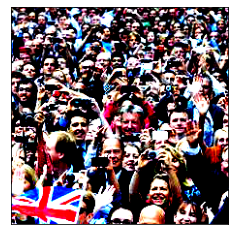

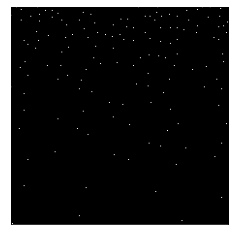

KeyboardInterrupt: 

In [14]:
trainer = Trainer()
trainer.setup()
trainer.train()